# KdV Equation Example

Anthony Gruber 3-31-2023

In [1]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# My imports
import OpInf_utils as ou
import ROM_utils as ru
import KdV_BBM_utils as ku

# To suppress annoying umfpack "almost singular" warnings
import warnings
warnings.filterwarnings('ignore', '.*singular matrix!.*')

## Generate and Train POD Bases

In [2]:
# Parameters for training
N  = 500
Nt = 1000
T  = 20

# Ranges for training
xTrain = np.linspace(-20, 20, N)
dx     = xTrain[1]-xTrain[0]
tTrain = np.linspace(0, T, Nt)

# # Define IC for FOM
ic = ku.KdV_soliton_IC(xTrain)
# ic = 1 / np.cosh(xTrain / np.sqrt(2)) + 2 / np.cosh(xTrain / np.sqrt(5))

# Assemble FOM and compute snapshots
A, B, E      = ku.build_KdV_mats(N, [-20,20])
X1, Xd1, gH1 = ku.integrate_KdV_v1_FOM(tTrain, ic, A, B)
X2, Xd2, gH2 = ku.integrate_KdV_v2_FOM(tTrain, ic, A, E)

# SVD of Snapshot Matrices
UU1mc, SS1mc = np.linalg.svd(X1-ic.reshape(-1,1))[:2]
UU1, SS1     = np.linalg.svd(X1)[:2]
UU2mc, SS2mc = np.linalg.svd(X2-ic.reshape(-1,1))[:2]
UU2, SS2     = np.linalg.svd(X2)[:2]

# Building operators for the ROMs
(OpListMC1, OpListMC1G, 
 OpListMC2, OpListMC2G) = ku.build_KdV_ROM_Ops([UU1mc,UU2mc], A,
                                                B, E, ic, MC=True)
(OpList1, OpList1G,
 OpList2, OpList2G)     = ku.build_KdV_ROM_Ops([UU1,UU2], A, 
                                                B, E, ic, MC=False)


### Plot snapshot energies and Hamiltonian quantities

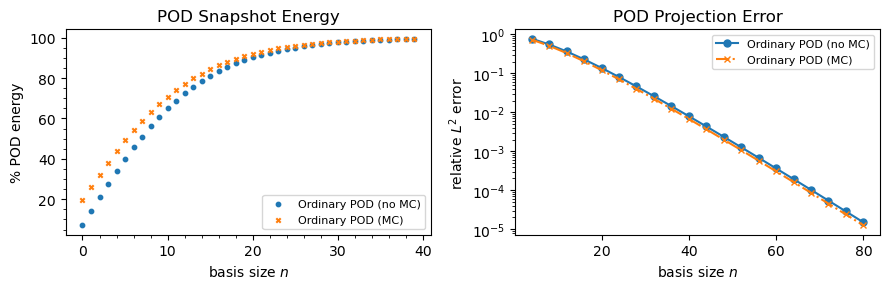

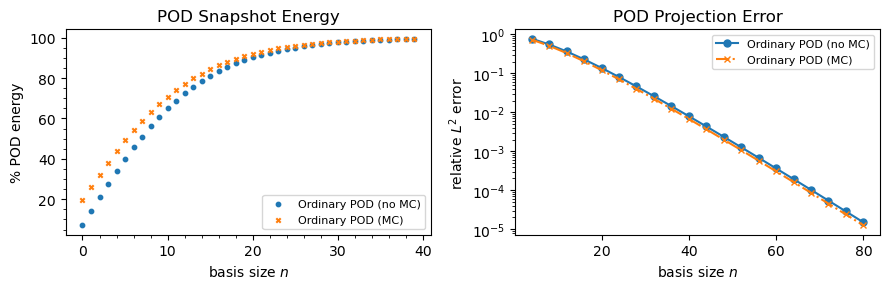

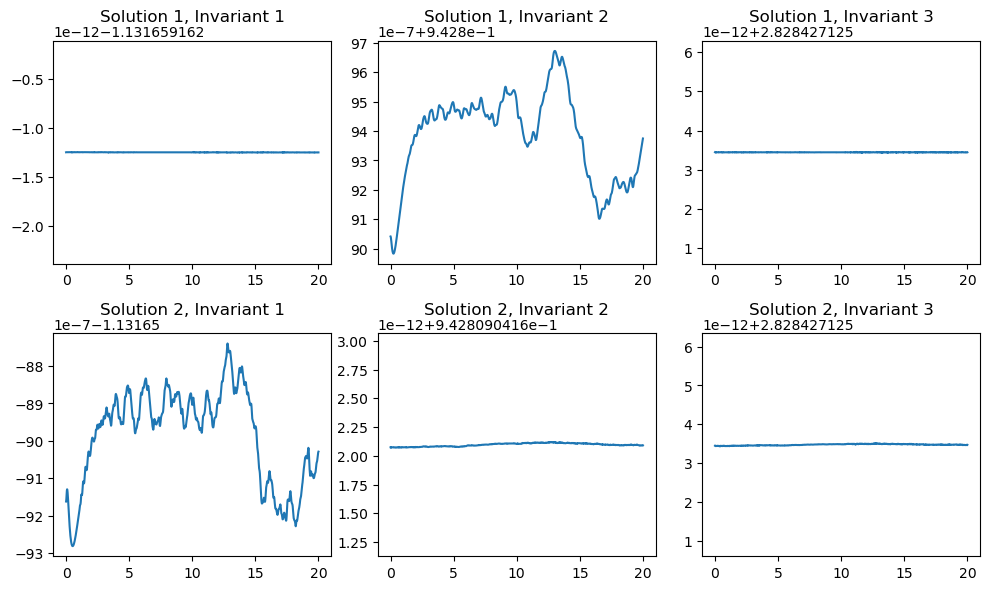

In [3]:
from matplotlib.ticker import StrMethodFormatter

nEigs = 40
idx = [i for i in range(nEigs)]

nList = [4*(i+1) for i in range(20)]
errUr  = np.zeros(len(nList))
errU2r = np.zeros(len(nList))
errUp  = np.zeros(len(nList))
errU2p = np.zeros(len(nList))
for i,n in enumerate(nList):
    Umc      = UU1mc[:,:n]
    U       = UU1[:,:n]
    reconU   = ic.reshape(-1,1) + Umc @ Umc.T @ (X1 - ic.reshape(-1,1))
    reconU2  = U @ U.T @ X1
    errUr[i]  = ru.relError(X1, reconU)
    errU2r[i] = ru.relError(X1, reconU2)

fig, ax = plt.subplots(1, 2, figsize=(9,3))
ax[0].scatter(idx, np.cumsum(SS1[:nEigs] / np.sum(SS1))*100, s=10, label='Ordinary POD (no MC)')
ax[0].scatter(idx, np.cumsum(SS1mc[:nEigs] / np.sum(SS1mc))*100, s=10, label='Ordinary POD (MC)', marker='x')
ax[0].set_title('POD Snapshot Energy')
# ax[0].set_yscale('log')
ax[1].semilogy(nList, errU2r, label='Ordinary POD (no MC)', marker='o', linestyle='-', markersize=5)
ax[1].semilogy(nList, errUr, label='Ordinary POD (MC)', marker='x', linestyle='-.', markersize=5)
ax[1].set_title('POD Projection Error')
ax[1].set_ylabel('relative $L^2$ error')
# ax[0].get_shared_y_axes().join(ax[0], ax[1])
# ax[1].set_xticklabels([])
for i in range(1):
    ax[i].minorticks_on()
    ax[i].yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax[i].set_ylabel('% POD energy')
for i in range(2):
    ax[i].set_xlabel('basis size $n$')
    ax[i].legend(prop={'size': 8})
plt.tight_layout()
# plt.savefig('KdVpodEnergy', transparent=True)
plt.show()


nList = [4*(i+1) for i in range(20)]
errUr  = np.zeros(len(nList))
errU2r = np.zeros(len(nList))
errUp  = np.zeros(len(nList))
errU2p = np.zeros(len(nList))
for i,n in enumerate(nList):
    Umc      = UU2mc[:,:n]
    U       = UU2[:,:n]
    reconU   = ic.reshape(-1,1) + Umc @ Umc.T @ (X1 - ic.reshape(-1,1))
    reconU2  = U @ U.T @ X1
    errUr[i]  = ru.relError(X1, reconU)
    errU2r[i] = ru.relError(X1, reconU2)

fig, ax = plt.subplots(1, 2, figsize=(9,3))
ax[0].scatter(idx, np.cumsum(SS2[:nEigs] / np.sum(SS2))*100, s=10, label='Ordinary POD (no MC)')
ax[0].scatter(idx, np.cumsum(SS2mc[:nEigs] / np.sum(SS2mc))*100, s=10, label='Ordinary POD (MC)', marker='x')
ax[0].set_title('POD Snapshot Energy')
# ax[0].set_yscale('log')
ax[1].semilogy(nList, errU2r, label='Ordinary POD (no MC)', marker='o', linestyle='-', markersize=5)
ax[1].semilogy(nList, errUr, label='Ordinary POD (MC)', marker='x', linestyle='-.', markersize=5)
ax[1].set_title('POD Projection Error')
ax[1].set_ylabel('relative $L^2$ error')
# ax[0].get_shared_y_axes().join(ax[0], ax[1])
# ax[1].set_xticklabels([])
for i in range(1):
    ax[i].minorticks_on()
    ax[i].yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax[i].set_ylabel('% POD energy')
for i in range(2):
    ax[i].set_xlabel('basis size $n$')
    ax[i].legend(prop={'size': 8})
plt.tight_layout()
# plt.savefig('KdV2podEnergy', transparent=True)
plt.show()


fig, ax = plt.subplots(2, 3, figsize=(10,6))
ax[0,0].plot(tTrain, ku.KdV_Hamil_v1(X1, dx))
ax[0,0].set_title('Solution 1, Invariant 1', y=1.05)
ax[0,1].plot(tTrain, ku.KdV_Hamil_v2(X1, dx))
ax[0,1].set_title('Solution 1, Invariant 2', y=1.05)
ax[0,2].plot(tTrain, np.sum(X1, axis=0)*dx)
ax[0,2].set_title('Solution 1, Invariant 3', y=1.05)
ax[1,0].plot(tTrain, ku.KdV_Hamil_v1(X2, dx))
ax[1,0].set_title('Solution 2, Invariant 1', y=1.05)
ax[1,1].plot(tTrain, ku.KdV_Hamil_v2(X2, dx))
ax[1,1].set_title('Solution 2, Invariant 2', y=1.05)
ax[1,2].plot(tTrain, np.sum(X2, axis=0)*dx)
ax[1,2].set_title('Solution 2, Invariant 3', y=1.05)
plt.tight_layout()
plt.show()

## Compute ROMs for Hamiltonian v1 (nonlinear Grad H)

### Reproductive case

the relative L2 errors for intrusive G-ROM (MC) are [1.36147428e+00 1.29918455e+00 1.21408168e+00 1.05709625e+00
 8.56232463e-01 4.91993974e-01 2.63488785e-01 1.18481474e-01
 5.28383956e-02 2.18031380e-02 8.91136032e-03 3.66870948e-03
 1.54039342e-03 6.94874762e-04 3.35635426e-04 1.68807340e-04
 8.73031114e-05 4.56304780e-05]
the relative L2 errors for intrusive G-ROM (no MC) are [1.07614659e+00 1.19254469e+00 1.20899412e+00 1.11068038e+00
 8.53246995e-01 5.20340394e-01 2.59180144e-01 2.66731761e-01
 6.55229196e-02 2.70471653e-02 4.24055326e-02 9.65697403e-03
 9.88074042e-03 3.53165812e-03 2.15879358e-03 1.29837381e-03
 7.52382031e-04 5.10909172e-04]
the relative L2 errors for intrusive H-ROM (MC) are [2.46708012e+00 1.77389072e+00 1.24537986e+00 9.50483765e-01
 4.66816688e-01 3.38367000e-01 1.93245137e-01 9.84025342e-02
 4.55388832e-02 1.97488844e-02 8.33840317e-03 3.46268094e-03
 1.51190348e-03 6.84009161e-04 3.33480144e-04 1.68290691e-04
 8.71924108e-05 4.56024098e-05]
the relative 

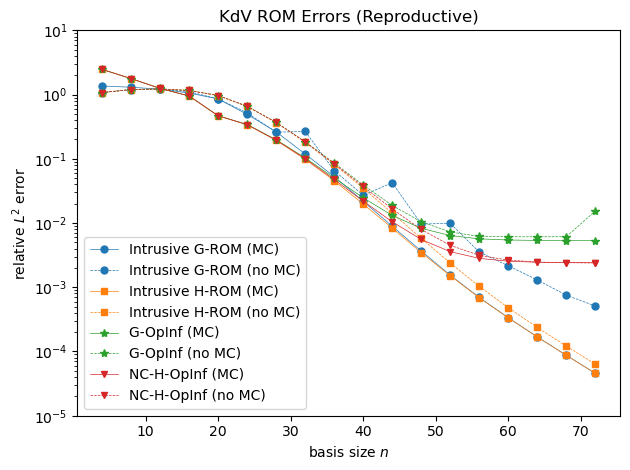

In [4]:
T         = 20
NtTest    = 1000
tTest     = np.linspace(0, T, NtTest)
dt        = tTest[1]-tTest[0]

OpListMC1ol = list(OpListMC1)
OpList1ol   = list(OpList1)

Xtest = ku.integrate_KdV_v1_FOM(tTest, ic, A, B)[0]
# Xtest = X1

gradHhat = UU1[:,:150].T @ gH1
XdotHat  = UU1[:,:150].T @ Xd1
rhsG     = gradHhat @ XdotHat.T
ghghT    = gradHhat @ gradHhat.T

gradHhat = UU1mc[:,:150].T @ gH1
XdotHat  = UU1mc[:,:150].T @ Xd1
rhsGmc   = gradHhat @ XdotHat.T
ghghTmc  = gradHhat @ gradHhat.T


nList   = [4*(i+1) for i in range(18)]
eOp     = np.zeros(len(nList))
eOpMC   = np.zeros(len(nList))
eIntG   = np.zeros(len(nList))
eIntH   = np.zeros(len(nList))
eIntGMC = np.zeros(len(nList))
eIntHMC = np.zeros(len(nList))
eHOp    = np.zeros(len(nList))
eHOpMC  = np.zeros(len(nList))


XrecIntG   = np.zeros((len(nList), N, NtTest))
XrecIntGMC = np.zeros((len(nList), N, NtTest))
XrecIntH   = np.zeros((len(nList), N, NtTest))
XrecIntHMC = np.zeros((len(nList), N, NtTest))
XrecHOp    = np.zeros((len(nList), N, NtTest))
XrecHOpMC  = np.zeros((len(nList), N, NtTest))
XrecOp     = np.zeros((len(nList), N, NtTest))
XrecOpMC   = np.zeros((len(nList), N, NtTest))

oneShot = True

OpInfLists  = ou.build_OpInf_stuff(UU1, X1, Xd1, gH1, A, nList[-1])
OpInfListMC = ou.build_OpInf_stuff(UU1mc, X1, Xd1, gH1, A, nList[-1], MC=True)

if oneShot:
    LhatHOpFullMC = ou.NC_H_OpInf(OpInfListMC, nList[-1], eps=0.0e-12)
    LhatHOpFull   = ou.NC_H_OpInf(OpInfLists[0], nList[-1], eps=0.0e-12)

# DhatOpFull = ou.G_OpInf(OpInfLists[-1], nList[-1], SS1, eps=1.0e-15)
DhatOpFull   = ou.G_OpInf([ghghT, rhsG], nList[-1], eps=0e-10)
DhatOpFullMC = ou.G_OpInf([ghghTmc, rhsGmc], nList[-1], eps=0e-10)

# i,n=19,nList[-1]
# if i==19 and n==nList[-1]:

for i,n in enumerate(nList):

    if oneShot:
        LhatHOp   = LhatHOpFull[:n,:n]
        LhatHOpMC = LhatHOpFullMC[:n,:n]
    else:
        LhatHOpMC = ou.NC_H_OpInf(OpInfListMC, n, eps=0.0e-12)
        LhatHOp   = ou.NC_H_OpInf(OpInfLists[0], n, eps=0.0e-12)    
    
    DhatOp   = DhatOpFull[:n,:n]
    DhatOpMC = DhatOpFullMC[:n,:n]
    # DhatOpFull  = ou.G_OpInf([ghghT, rhsG], n, eps=1e-12)

    OpList1ol[-1]   = LhatHOp
    OpListMC1ol[-1] = LhatHOpMC

    XrecIntGMC[i] = ku.integrate_KdV_v1_ROM(tTest, OpListMC1G, ic, UU1mc, n, 
                                            Hamiltonian=False, MC=True, Newton=True)
    XrecIntHMC[i] = ku.integrate_KdV_v1_ROM(tTest, OpListMC1, ic, UU1mc, n, 
                                            Hamiltonian=True, MC=True, Newton=True)
    XrecHOpMC[i]  = ku.integrate_KdV_v1_ROM(tTest, OpListMC1ol, ic, UU1mc, n,
                                            Hamiltonian=True, MC=True, Newton=True)
    XrecIntG[i]   = ku.integrate_KdV_v1_ROM(tTest, OpList1G, ic, UU1, n, 
                                            Hamiltonian=False, MC=False, Newton=True)
    XrecIntH[i]   = ku.integrate_KdV_v1_ROM(tTest, OpList1, ic, UU1, n, 
                                            Hamiltonian=True, MC=False, Newton=True)
    XrecHOp[i]    = ku.integrate_KdV_v1_ROM(tTest, OpList1ol, ic, UU1, n,
                                            Hamiltonian=True, MC=False, Newton=True)
    # XrecOp    = ru.integrate_OpInf_ROM(tTest, DhatOp, ic, UU1)
    OpList1ol[-1]   = DhatOp
    OpListMC1ol[-1] = DhatOpMC
    XrecOp[i]    = ku.integrate_KdV_v1_ROM(tTest, OpList1ol, ic, UU1, n,
                                           Hamiltonian=True, MC=False, Newton=True)
    XrecOpMC[i]  = ku.integrate_KdV_v1_ROM(tTest, OpListMC1ol, ic, UU1mc, n,
                                           Hamiltonian=True, MC=True, Newton=True)

    eIntG[i]   = ru.relError(Xtest, XrecIntG[i])
    eIntGMC[i] = ru.relError(Xtest, XrecIntGMC[i])
    eIntH[i]   = ru.relError(Xtest, XrecIntH[i])
    eIntHMC[i] = ru.relError(Xtest, XrecIntHMC[i])
    eHOp[i]    = ru.relError(Xtest, XrecHOp[i])
    eHOpMC[i]  = ru.relError(Xtest, XrecHOpMC[i])
    eOp[i]     = ru.relError(Xtest, XrecOp[i])
    eOpMC[i]   = ru.relError(Xtest, XrecOpMC[i])

# Print error magnitudes
print(f'the relative L2 errors for intrusive G-ROM (MC) are {eIntGMC}')
print(f'the relative L2 errors for intrusive G-ROM (no MC) are {eIntG}')
print(f'the relative L2 errors for intrusive H-ROM (MC) are {eIntHMC}')
print(f'the relative L2 errors for intrusive H-ROM (no MC) are {eIntH}')
print(f'the relative L2 errors for NC-H-OpInf (MC) are {eHOpMC}')
print(f'the relative L2 errors for NC-H-OpInf (no MC) are {eHOp}')
print(f'the relative L2 errors for G-OpInf (MC) are {eOpMC}')
print(f'the relative L2 errors for G-OpInf (no MC) are {eOp}')

name = "tab10"
cmap = get_cmap(name)

plt.semilogy(nList, eIntGMC, label='Intrusive G-ROM (MC)',
             marker='o', linestyle='-', color=cmap.colors[0], linewidth=0.5, markersize=5)
plt.semilogy(nList, eIntG, label='Intrusive G-ROM (no MC)',
             marker='o', linestyle='--', color=cmap.colors[0], linewidth=0.5, markersize=5)
plt.semilogy(nList, eIntHMC, label='Intrusive H-ROM (MC)',
             marker='s', linestyle='-', color=cmap.colors[1], linewidth=0.5, markersize=5)
plt.semilogy(nList, eIntH, label='Intrusive H-ROM (no MC)',
             marker='s', linestyle='--', color=cmap.colors[1], linewidth=0.5, markersize=5)
plt.semilogy(nList, eOpMC, label='G-OpInf (MC)',
             marker='*', linestyle='-', color=cmap.colors[2], linewidth=0.5, markersize=6)
plt.semilogy(nList, eOp,  label='G-OpInf (no MC)',
             marker='*', linestyle='--', color=cmap.colors[2], linewidth=0.5, markersize=6)
plt.semilogy(nList, eHOpMC, label='NC-H-OpInf (MC)',
             marker='v', linestyle='-', color=cmap.colors[3], linewidth=0.5, markersize=5)
plt.semilogy(nList, eHOp, label='NC-H-OpInf (no MC)',
             marker='v', linestyle='--', color=cmap.colors[3], linewidth=0.5, markersize=5)
plt.ylabel('relative $L^2$ error')
plt.xlabel('basis size $n$')
plt.title('KdV ROM Errors (Reproductive)')
plt.ylim([10**-5,10])
plt.legend(loc=3)

plt.tight_layout()
# plt.savefig(f'KdVPlotT{T}', transparent=True)
plt.show()

### Plot conserved quantities in reproductive case

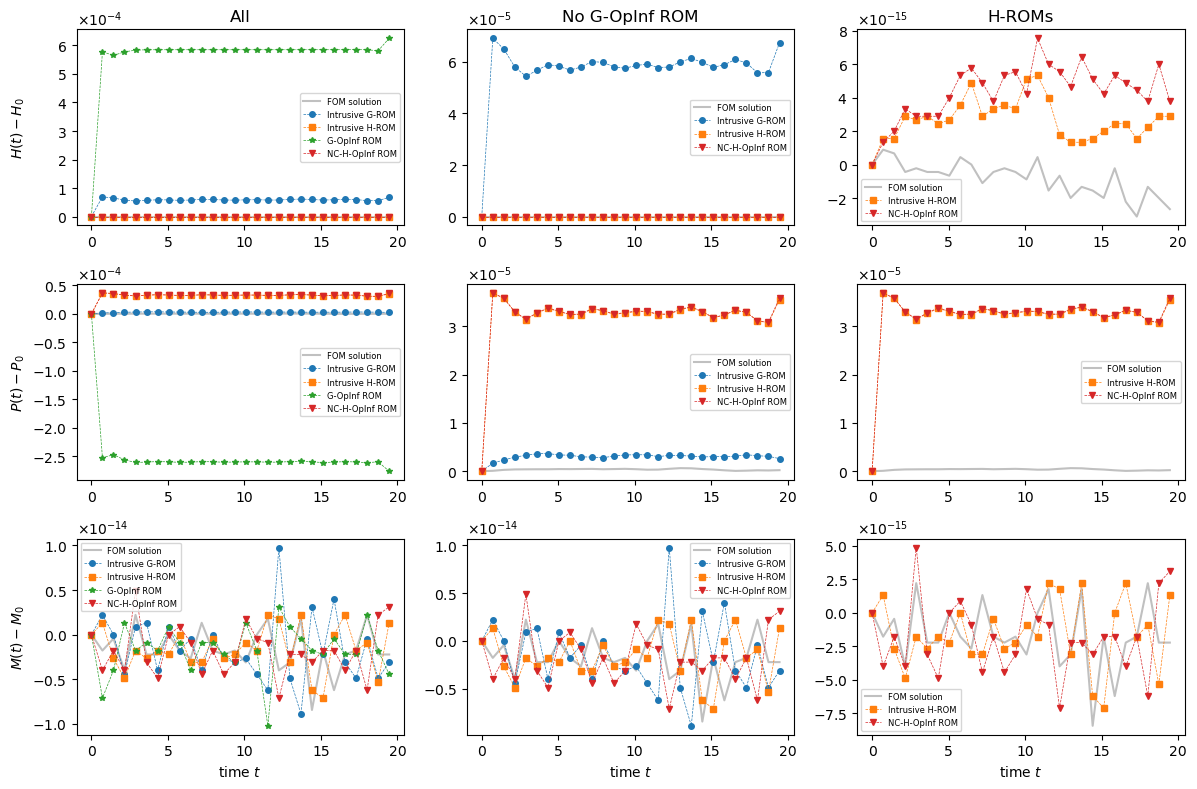

/var/folders/fm/5nmtz1sx0qgfhs9hqsd70ycc00434g/T/ipykernel_97423/277079341.py:136: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


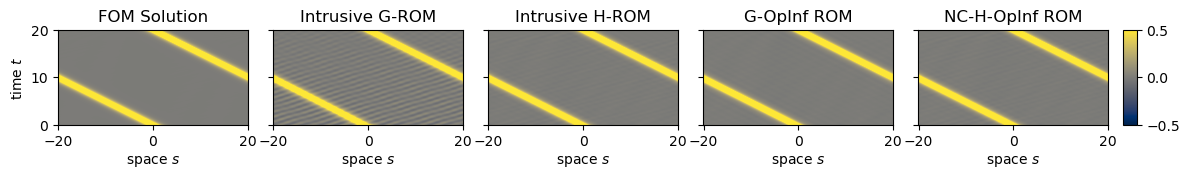

In [5]:
i=11
fig, ax = plt.subplots(3, 3, figsize=(12,8))


yLabelList   = [r'$H(t) - H_0$', r'$P(t) - P_0$', r'$M(t) - M_0$']
titleList    = ['All', 'No G-OpInf ROM', 'H-ROMs']

exact   = ku.KdV_Hamil_v1(Xtest, dx)
IntGerr = ku.KdV_Hamil_v1(XrecIntGMC[i], dx)
IntHerr = ku.KdV_Hamil_v1(XrecIntHMC[i], dx)
Operr   = ku.KdV_Hamil_v1(XrecOpMC[i], dx)
OpHerr  = ku.KdV_Hamil_v1(XrecHOpMC[i], dx)

exact  -=exact[0]
IntGerr-=IntGerr[0]
IntHerr-=IntHerr[0]
Operr  -=Operr[0]
OpHerr -=OpHerr[0]

skip=36

ax[0,0].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[0,0].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[0,0].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[0,0].plot(tTest[::skip], Operr[::skip], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax[0,0].plot(tTest[::skip], OpHerr[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax[0,1].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[0,1].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[0,1].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[0,1].plot(tTest[::skip], OpHerr[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax[0,2].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[0,2].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[0,2].plot(tTest[::skip], OpHerr[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)

exact   = ku.KdV_Hamil_v2(Xtest, dx)
IntGerr = ku.KdV_Hamil_v2(XrecIntGMC[i], dx)
IntHerr = ku.KdV_Hamil_v2(XrecIntHMC[i], dx)
Operr   = ku.KdV_Hamil_v2(XrecOpMC[i], dx)
OpHerr  = ku.KdV_Hamil_v2(XrecHOpMC[i], dx)

exact  -=exact[0]
IntGerr-=IntGerr[0]
IntHerr-=IntHerr[0]
Operr  -=Operr[0]
OpHerr -=OpHerr[0]

ax[1,0].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[1,0].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[1,0].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[1,0].plot(tTest[::skip], Operr[::skip], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax[1,0].plot(tTest[::skip], OpHerr[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax[1,1].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[1,1].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[1,1].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[1,1].plot(tTest[::skip], OpHerr[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax[1,2].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
# ax[1,2].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[1,2].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[1,2].plot(tTest[::skip], OpHerr[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)

exact   = np.sum(Xtest,0)*dx
IntGerr = np.sum(XrecIntGMC[i],0)*dx
IntHerr = np.sum(XrecIntHMC[i],0)*dx
Operr   = np.sum(XrecOpMC[i],0)*dx
OpHerr  = np.sum(XrecHOpMC[i],0)*dx

exact  -=exact[0]
IntGerr-=IntGerr[0]
IntHerr-=IntHerr[0]
Operr  -=Operr[0]
OpHerr -=OpHerr[0]

ax[2,0].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[2,0].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[2,0].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[2,0].plot(tTest[::skip], Operr[::skip], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax[2,0].plot(tTest[::skip], OpHerr[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax[2,1].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[2,1].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[2,1].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[2,1].plot(tTest[::skip], OpHerr[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax[2,2].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[2,2].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[2,2].plot(tTest[::skip], OpHerr[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)

for j in range(9):
    ax.flatten()[j].legend(prop={'size':6})
    ax.flatten()[j].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
for j in range(3):
    ax[j,0].set_ylabel(f'{yLabelList[j]}', loc='center', labelpad=2.0)
    ax[j,0].yaxis.set_label_coords(-0.15,0.5)
    ax[-1,j].set_xlabel('time $t$')
    ax[0,j].set_title(f'{titleList[j]}')


plt.tight_layout()
plt.savefig(f'KdVConserved{4*(i+1)}modesT{T}', transparent=True)
plt.show()

# =0.9*(Xtest.shape[0]/Xtest.shape[1])

i=7
dx = xTrain[1]-xTrain[0]
dt = tTest[1]-tTest[0]
extent = [xTrain[0]-dx, xTrain[-1]+dx, tTest[0]-dt, tTest[-1]+dt]

titleList = ['FOM Solution', 'Intrusive G-ROM', 'Intrusive H-ROM', 'G-OpInf ROM', 'NC-H-OpInf ROM']

from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(12,4))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,5),
                 axes_pad=0.25,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

im = grid[0].imshow(Xtest.T, extent=extent, cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[1].imshow(XrecIntG[i].T, extent=extent, cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[2].imshow(XrecIntHMC[i].T, extent=extent, cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[3].imshow(XrecOp[i].T, extent=extent, cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[4].imshow(XrecHOpMC[i].T, extent=extent, cmap='cividis', vmin=-0.5, vmax=0.5)
for j in range(5):
    grid[j].set_title(f'{titleList[j]}')
    grid[j].set_xlabel('space $s$')
grid[0].set_ylabel('time $t$')

grid[-1].cax.colorbar(im)
grid[-1].cax.toggle_label(True)

plt.tight_layout()
# plt.savefig(f'KdVimshow{4*(i+1)}ModesT{T}', transparent=True, bbox_inches='tight')
plt.show()

### Compute ROMs in predictive case

the relative L2 errors for intrusive G-ROM (MC) are [1.34697732e+00 1.36314798e+00 1.34537862e+00 1.32579847e+00
 1.31314812e+00 1.21193062e+00 9.52437997e-01 5.32013971e-01
 2.41227348e-01 9.57178450e-02 3.69811643e-02 1.38704955e-02
 5.03912658e-03 1.82045935e-03 6.68314710e-04 2.60105226e-04
 1.11448842e-04 5.25897945e-05]
the relative L2 errors for intrusive G-ROM (no MC) are [1.04592757e+00 1.18560099e+00 1.26894174e+00 1.34187407e+00
 1.30405381e+00 1.19574279e+00 8.96562524e-01 5.28996159e-01
 4.46220420e-01 4.21401457e-02 2.25376959e-02 1.18038774e-02
 7.53321825e-03 8.90276314e-03 2.35504269e-03 1.85890719e-03
 1.10587806e-03 4.90460432e-04]
the relative L2 errors for intrusive H-ROM (MC) are [9.34987288e+04 9.36184196e+04 8.42297525e+03 1.40057601e+00
 1.24197116e+00 8.44631050e-01 6.19688327e-01 4.12919064e-01
 1.90934060e-01 8.19139577e-02 3.27497450e-02 1.24570694e-02
 4.62228080e-03 1.69280730e-03 6.31227951e-04 2.50473679e-04
 1.09104292e-04 5.21274716e-05]
the relative 

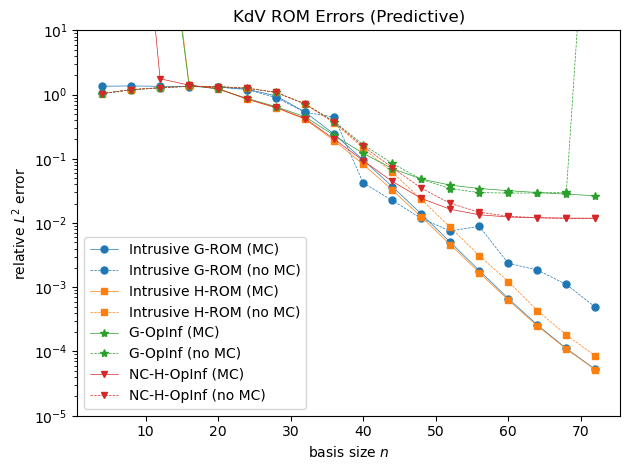

In [6]:
T         = 100
NtTest    = 1000
tTest     = np.linspace(0, T, NtTest)
dt        = tTest[1]-tTest[0]

OpListMC1ol = list(OpListMC1)
OpList1ol   = list(OpList1)

Xtest = ku.integrate_KdV_v1_FOM(tTest, ic, A, B)[0]
# Xtest = X1

gradHhat = UU1[:,:150].T @ gH1
XdotHat  = UU1[:,:150].T @ Xd1
rhsG     = gradHhat @ XdotHat.T
ghghT    = gradHhat @ gradHhat.T

gradHhat = UU1mc[:,:150].T @ gH1
XdotHat  = UU1mc[:,:150].T @ Xd1
rhsGmc   = gradHhat @ XdotHat.T
ghghTmc  = gradHhat @ gradHhat.T


nList   = [4*(i+1) for i in range(18)]
eOp     = np.zeros(len(nList))
eOpMC   = np.zeros(len(nList))
eIntG   = np.zeros(len(nList))
eIntH   = np.zeros(len(nList))
eIntGMC = np.zeros(len(nList))
eIntHMC = np.zeros(len(nList))
eHOp    = np.zeros(len(nList))
eHOpMC  = np.zeros(len(nList))


XrecIntG   = np.zeros((len(nList), N, NtTest))
XrecIntGMC = np.zeros((len(nList), N, NtTest))
XrecIntH   = np.zeros((len(nList), N, NtTest))
XrecIntHMC = np.zeros((len(nList), N, NtTest))
XrecHOp    = np.zeros((len(nList), N, NtTest))
XrecHOpMC  = np.zeros((len(nList), N, NtTest))
XrecOp     = np.zeros((len(nList), N, NtTest))
XrecOpMC   = np.zeros((len(nList), N, NtTest))

oneShot = True

OpInfLists  = ou.build_OpInf_stuff(UU1, X1, Xd1, gH1, A, nList[-1])
OpInfListMC = ou.build_OpInf_stuff(UU1mc, X1, Xd1, gH1, A, nList[-1], MC=True)

if oneShot:
    LhatHOpFullMC = ou.NC_H_OpInf(OpInfListMC, nList[-1], eps=0.0e-12)
    LhatHOpFull   = ou.NC_H_OpInf(OpInfLists[0], nList[-1], eps=0.0e-12)

# DhatOpFull = ou.G_OpInf(OpInfLists[-1], nList[-1], SS1, eps=1.0e-15)
DhatOpFull   = ou.G_OpInf([ghghT, rhsG], nList[-1], eps=0e-10)
DhatOpFullMC = ou.G_OpInf([ghghTmc, rhsGmc], nList[-1], eps=0e-10)

# i,n=19,nList[-1]
# if i==19 and n==nList[-1]:

for i,n in enumerate(nList):

    if oneShot:
        LhatHOp   = LhatHOpFull[:n,:n]
        LhatHOpMC = LhatHOpFullMC[:n,:n]
    else:
        LhatHOpMC = ou.NC_H_OpInf(OpInfListMC, n, eps=0.0e-12)
        LhatHOp   = ou.NC_H_OpInf(OpInfLists[0], n, eps=0.0e-12)    
    
    DhatOp   = DhatOpFull[:n,:n]
    DhatOpMC = DhatOpFullMC[:n,:n]
    # DhatOpFull  = ou.G_OpInf([ghghT, rhsG], n, eps=1e-12)

    OpList1ol[-1]   = LhatHOp
    OpListMC1ol[-1] = LhatHOpMC

    XrecIntGMC[i] = ku.integrate_KdV_v1_ROM(tTest, OpListMC1G, ic, UU1mc, n, 
                                            Hamiltonian=False, MC=True, Newton=True)
    XrecIntHMC[i] = ku.integrate_KdV_v1_ROM(tTest, OpListMC1, ic, UU1mc, n, 
                                            Hamiltonian=True, MC=True, Newton=True)
    XrecHOpMC[i]  = ku.integrate_KdV_v1_ROM(tTest, OpListMC1ol, ic, UU1mc, n,
                                            Hamiltonian=True, MC=True, Newton=True)
    XrecIntG[i]   = ku.integrate_KdV_v1_ROM(tTest, OpList1G, ic, UU1, n, 
                                            Hamiltonian=False, MC=False, Newton=True)
    XrecIntH[i]   = ku.integrate_KdV_v1_ROM(tTest, OpList1, ic, UU1, n, 
                                            Hamiltonian=True, MC=False, Newton=True)
    XrecHOp[i]    = ku.integrate_KdV_v1_ROM(tTest, OpList1ol, ic, UU1, n,
                                            Hamiltonian=True, MC=False, Newton=True)
    # XrecOp    = ru.integrate_OpInf_ROM(tTest, DhatOp, ic, UU1)
    OpList1ol[-1]   = DhatOp
    OpListMC1ol[-1] = DhatOpMC
    XrecOp[i]    = ku.integrate_KdV_v1_ROM(tTest, OpList1ol, ic, UU1, n,
                                           Hamiltonian=True, MC=False, Newton=True)
    XrecOpMC[i]  = ku.integrate_KdV_v1_ROM(tTest, OpListMC1ol, ic, UU1mc, n,
                                           Hamiltonian=True, MC=True, Newton=True)

    eIntG[i]   = ru.relError(Xtest, XrecIntG[i])
    eIntGMC[i] = ru.relError(Xtest, XrecIntGMC[i])
    eIntH[i]   = ru.relError(Xtest, XrecIntH[i])
    eIntHMC[i] = ru.relError(Xtest, XrecIntHMC[i])
    eHOp[i]    = ru.relError(Xtest, XrecHOp[i])
    eHOpMC[i]  = ru.relError(Xtest, XrecHOpMC[i])
    eOp[i]     = ru.relError(Xtest, XrecOp[i])
    eOpMC[i]   = ru.relError(Xtest, XrecOpMC[i])

# Print error magnitudes
print(f'the relative L2 errors for intrusive G-ROM (MC) are {eIntGMC}')
print(f'the relative L2 errors for intrusive G-ROM (no MC) are {eIntG}')
print(f'the relative L2 errors for intrusive H-ROM (MC) are {eIntHMC}')
print(f'the relative L2 errors for intrusive H-ROM (no MC) are {eIntH}')
print(f'the relative L2 errors for NC-H-OpInf (MC) are {eHOpMC}')
print(f'the relative L2 errors for NC-H-OpInf (no MC) are {eHOp}')
print(f'the relative L2 errors for G-OpInf (MC) are {eOpMC}')
print(f'the relative L2 errors for G-OpInf (no MC) are {eOp}')

name = "tab10"
cmap = get_cmap(name)

plt.semilogy(nList, eIntGMC, label='Intrusive G-ROM (MC)',
             marker='o', linestyle='-', color=cmap.colors[0], linewidth=0.5, markersize=5)
plt.semilogy(nList, eIntG, label='Intrusive G-ROM (no MC)',
             marker='o', linestyle='--', color=cmap.colors[0], linewidth=0.5, markersize=5)
plt.semilogy(nList, eIntHMC, label='Intrusive H-ROM (MC)',
             marker='s', linestyle='-', color=cmap.colors[1], linewidth=0.5, markersize=5)
plt.semilogy(nList, eIntH, label='Intrusive H-ROM (no MC)',
             marker='s', linestyle='--', color=cmap.colors[1], linewidth=0.5, markersize=5)
plt.semilogy(nList, eOpMC, label='G-OpInf (MC)',
             marker='*', linestyle='-', color=cmap.colors[2], linewidth=0.5, markersize=6)
plt.semilogy(nList, eOp,  label='G-OpInf (no MC)',
             marker='*', linestyle='--', color=cmap.colors[2], linewidth=0.5, markersize=6)
plt.semilogy(nList, eHOpMC, label='NC-H-OpInf (MC)',
             marker='v', linestyle='-', color=cmap.colors[3], linewidth=0.5, markersize=5)
plt.semilogy(nList, eHOp, label='NC-H-OpInf (no MC)',
             marker='v', linestyle='--', color=cmap.colors[3], linewidth=0.5, markersize=5)
plt.ylabel('relative $L^2$ error')
plt.xlabel('basis size $n$')
plt.title('KdV ROM Errors (Predictive)')
plt.ylim([10**-5,10])
plt.legend(loc=3)

plt.tight_layout()
# plt.savefig(f'KdVPlotT{T}', transparent=True)
plt.show()

In [7]:
### Make movie of solutions

# i=11

# arrs = np.stack([Xtest, XrecIntG[i], XrecIntHMC[i],
#                  XrecOp[i], XrecHOpMC[i]], axis=0)

# styles = ['-', '--', '--', '-.', '-.']
# labels = ['FOM Solution', 'Intrusive G-ROM', 'Intrusive H-ROM', 'OpInf G-ROM', 'OpInf H-ROM']

# ru.animate_array(arrs, styles, labels, xTrain)

### Plot conserved quantities in predictive case

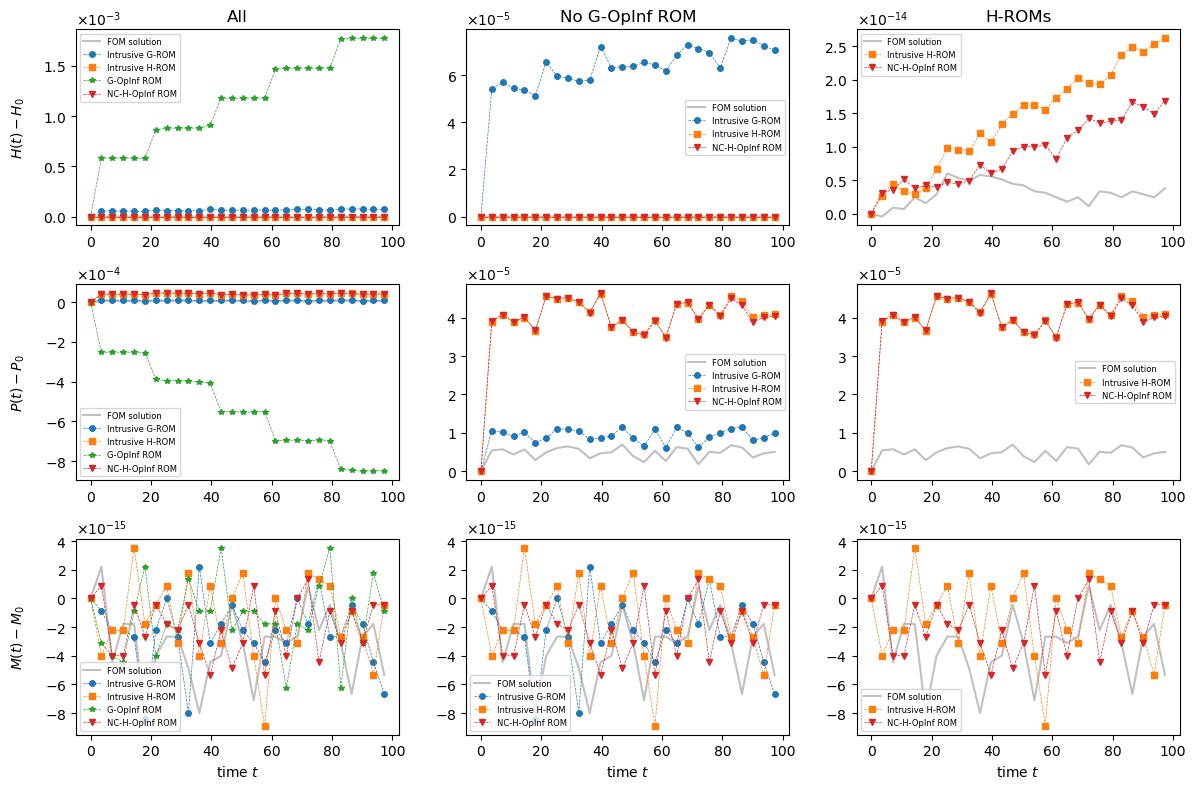

/var/folders/fm/5nmtz1sx0qgfhs9hqsd70ycc00434g/T/ipykernel_97423/1470708408.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


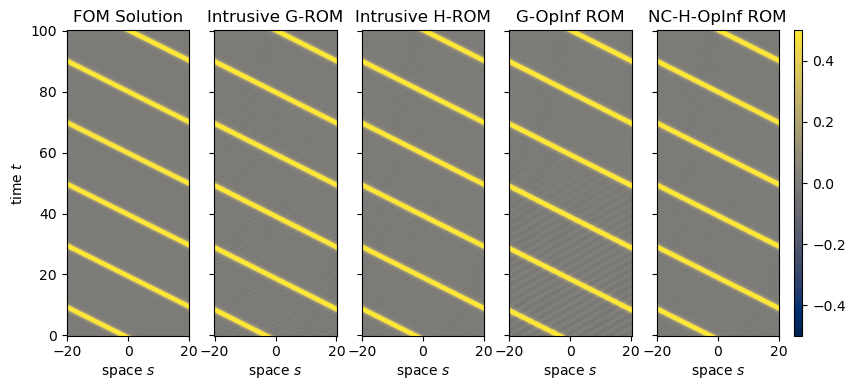

In [8]:
i=11
fig, ax = plt.subplots(3, 3, figsize=(12,8))


yLabelList   = [r'$H(t) - H_0$', r'$P(t) - P_0$', r'$M(t) - M_0$']
titleList    = ['All', 'No G-OpInf ROM', 'H-ROMs']

exact   = ku.KdV_Hamil_v1(Xtest, dx)
IntGerr = ku.KdV_Hamil_v1(XrecIntGMC[i], dx)
IntHerr = ku.KdV_Hamil_v1(XrecIntHMC[i], dx)
Operr   = ku.KdV_Hamil_v1(XrecOpMC[i], dx)
OpHerr  = ku.KdV_Hamil_v1(XrecHOpMC[i], dx)

exact  -=exact[0]
IntGerr-=IntGerr[0]
IntHerr-=IntHerr[0]
Operr  -=Operr[0]
OpHerr -=OpHerr[0]

skip=36

ax[0,0].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[0,0].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[0,0].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[0,0].plot(tTest[::skip], Operr[::skip], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax[0,0].plot(tTest[::skip], OpHerr[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax[0,1].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[0,1].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[0,1].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[0,1].plot(tTest[::skip], OpHerr[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax[0,2].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[0,2].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[0,2].plot(tTest[::skip], OpHerr[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)

exact   = ku.KdV_Hamil_v2(Xtest, dx)
IntGerr = ku.KdV_Hamil_v2(XrecIntGMC[i], dx)
IntHerr = ku.KdV_Hamil_v2(XrecIntHMC[i], dx)
Operr   = ku.KdV_Hamil_v2(XrecOpMC[i], dx)
OpHerr  = ku.KdV_Hamil_v2(XrecHOpMC[i], dx)

exact  -=exact[0]
IntGerr-=IntGerr[0]
IntHerr-=IntHerr[0]
Operr  -=Operr[0]
OpHerr -=OpHerr[0]

ax[1,0].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[1,0].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[1,0].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[1,0].plot(tTest[::skip], Operr[::skip], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax[1,0].plot(tTest[::skip], OpHerr[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax[1,1].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[1,1].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[1,1].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[1,1].plot(tTest[::skip], OpHerr[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax[1,2].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
# ax[1,2].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[1,2].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[1,2].plot(tTest[::skip], OpHerr[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)

exact   = np.sum(Xtest,0)*dx
IntGerr = np.sum(XrecIntGMC[i],0)*dx
IntHerr = np.sum(XrecIntHMC[i],0)*dx
Operr   = np.sum(XrecOpMC[i],0)*dx
OpHerr  = np.sum(XrecHOpMC[i],0)*dx

exact  -=exact[0]
IntGerr-=IntGerr[0]
IntHerr-=IntHerr[0]
Operr  -=Operr[0]
OpHerr -=OpHerr[0]

ax[2,0].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[2,0].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[2,0].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[2,0].plot(tTest[::skip], Operr[::skip], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax[2,0].plot(tTest[::skip], OpHerr[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax[2,1].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[2,1].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[2,1].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[2,1].plot(tTest[::skip], OpHerr[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax[2,2].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[2,2].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[2,2].plot(tTest[::skip], OpHerr[::skip], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)

for j in range(9):
    ax.flatten()[j].legend(prop={'size':6})
    ax.flatten()[j].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
for j in range(3):
    ax[j,0].set_ylabel(f'{yLabelList[j]}', loc='center', labelpad=2.0)
    ax[j,0].yaxis.set_label_coords(-0.15,0.5)
    ax[-1,j].set_xlabel('time $t$')
    ax[0,j].set_title(f'{titleList[j]}')


plt.tight_layout()
# plt.savefig(f'KdVConserved{4*(i+1)}modesT{T}', transparent=True)
plt.show()

i=7
dx = xTrain[1]-xTrain[0]
dt = tTest[1]-tTest[0]
extent = [xTrain[0]-dx, xTrain[-1]+dx, tTest[0]-dt, tTest[-1]+dt]

titleList = ['FOM Solution', 'Intrusive G-ROM', 'Intrusive H-ROM', 'G-OpInf ROM', 'NC-H-OpInf ROM']

from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(12,4))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,5),
                 axes_pad=0.25,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

im = grid[0].imshow(Xtest.T, extent=extent, cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[1].imshow(XrecIntGMC[i].T, extent=extent, cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[2].imshow(XrecIntHMC[i].T, extent=extent, cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[3].imshow(XrecOp[i].T, extent=extent, cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[4].imshow(XrecHOpMC[i].T, extent=extent, cmap='cividis', vmin=-0.5, vmax=0.5)
for j in range(5):
    grid[j].set_title(f'{titleList[j]}')
    grid[j].set_xlabel('space $s$')
grid[0].set_ylabel('time $t$')

grid[-1].cax.colorbar(im)
grid[-1].cax.toggle_label(True)

plt.tight_layout()
# plt.savefig(f'KdVimshow{4*(i+1)}ModesT{T}', transparent=True, bbox_inches='tight')
plt.show()

### Make some solution plots for predictive case

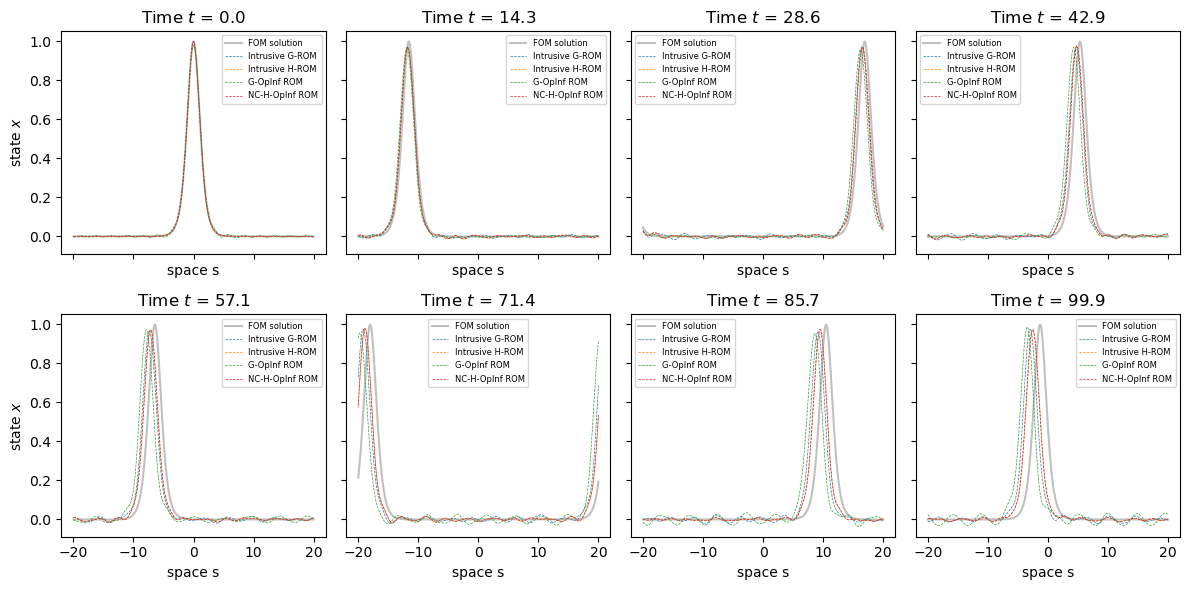

the times are [  0.          14.31431431  28.62862863  42.94294294  57.15715716
  71.47147147  85.78578579 100.        ]


In [9]:
i=7

name = "tab10"
cmap = plt.get_cmap(name)

fig, ax = plt.subplots(2, 4, figsize=(12,6), sharex=True, sharey=True)

ax.flatten()[0].set_ylabel(f'state $x$')
ax.flatten()[4].set_ylabel(f'state $x$')

tList = [int(np.ceil(999/7*i)) for i in range(8)]
for l,t in enumerate(tList):
    ax.flatten()[l].plot(xTrain, Xtest[:,t], label='FOM solution', color='silver', linestyle='-')
    ax.flatten()[l].plot(xTrain, XrecIntGMC[i][:,t], label='Intrusive G-ROM', color=cmap.colors[0], linestyle='--', linewidth=0.5, markersize=0.1)
    ax.flatten()[l].plot(xTrain, XrecIntHMC[i][:,t], label='Intrusive H-ROM', color=cmap.colors[1], linestyle='--', linewidth=0.5, markersize=0.1)
    ax.flatten()[l].plot(xTrain, XrecOp[i][:,t], label='G-OpInf ROM', color=cmap.colors[2], linestyle='--', linewidth=0.5, markersize=0.1)
    ax.flatten()[l].plot(xTrain, XrecHOpMC[i][:,t], label='NC-H-OpInf ROM', color=cmap.colors[3], linestyle='--', linewidth=0.5, markersize=0.1)
    # ax.flatten()[l].plot(xTrain, XrecOpA[i,j,k][:Nover2,t], label='C-H-OpInf ROM', color=cmap.colors[4], linestyle='--', linewidth=0.5, markersize=0.1)
    # ax.flatten()[j].set_ylim([-0.4,7.5])
    ax.flatten()[l].set_title(f'Time $t$ = {t/10}')
    ax.flatten()[l].set_xlabel(f'space s')

    ax.flatten()[l].legend(prop={'size':6})
plt.tight_layout()
# plt.savefig(f'KdVSoln{4*(i+1)}ModesT{T}', transparent=True)
plt.show()

print(f'the times are {tTest[tList]}')


# labs = ['FOM solution', 'Intrusive G-ROM', 'Intrusive H-ROM', 'G-OpInf ROM', 'NC-H-OpInf ROM']
# styls = ['-', '--', '--', '-.', '-.']

# ru.animate_array(np.array([Xtest, XrecIntGMC[i], XrecIntHMC[i], XrecOp[i], XrecHOp[i]]), styls, labs, xTrain)

## Compute ROMs for Hamiltonian v2 (Nonlinear L)

### Reproductive case

the relative L2 errors for intrusive H-ROM (MC) are [1.36461134 1.32873808 1.27404067 1.20757722 1.11725805 1.01247389
 0.92221691 0.86943038 0.84071214 0.82751245 0.82180514 0.81951424
 0.81863644 0.81831267 0.81819698 0.81815669 0.81814295 0.81813836]
the relative L2 errors for intrusive H-ROM (no MC) are [1.07352743e+00 1.19152166e+00 1.20871834e+00 1.11067914e+00
 8.53712437e-01 5.20462494e-01 2.58933362e-01 2.67370316e-01
 6.55805398e-02 2.71574962e-02 4.21803581e-02 9.71078233e-03
 9.84685728e-03 3.55889010e-03 2.17982171e-03 1.31454161e-03
 7.63822022e-04 5.22092551e-04]
the relative L2 errors for intrusive G-ROM (MC) are [1.36105604e+00 1.29884896e+00 1.21385139e+00 1.05708012e+00
 8.56582909e-01 4.92065351e-01 2.63647361e-01 1.18585765e-01
 5.29095393e-02 2.18318010e-02 8.92826939e-03 3.68169372e-03
 1.54888780e-03 7.00909210e-04 3.39712427e-04 1.71334721e-04
 8.88351979e-05 4.65390426e-05]
the relative L2 errors for intrusive G-ROM (no MC) are [1.07352743e+00 1.19152166e+00 1

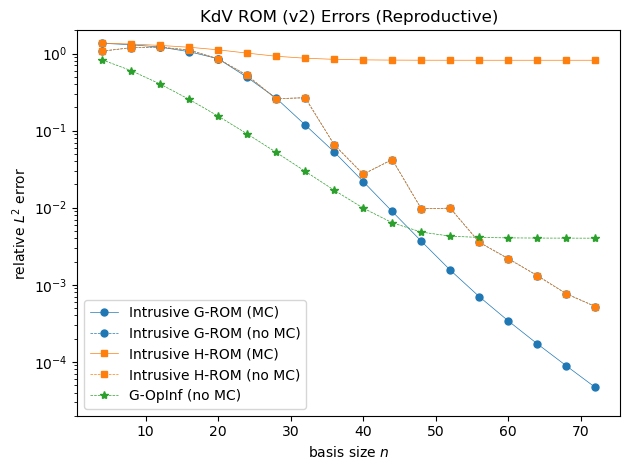

In [10]:
T         = 20
NtTest    = 1000
tTest     = np.linspace(0, T, NtTest)
dt        = tTest[1]-tTest[0]

Xtest = ku.integrate_KdV_v2_FOM(tTest, ic, A, E)[0]
# Xtest = X2

nList  = [4*(i+1) for i in range(18)]
eOp    = np.zeros(len(nList))
eIntG   = np.zeros(len(nList))
eIntGMC = np.zeros(len(nList))
eIntH   = np.zeros(len(nList))
eIntHMC = np.zeros(len(nList))

XrecIntG   = np.zeros((len(nList), N, NtTest))
XrecIntGMC = np.zeros((len(nList), N, NtTest))
XrecIntH   = np.zeros((len(nList), N, NtTest))
XrecIntHMC = np.zeros((len(nList), N, NtTest))
XrecOp     = np.zeros((len(nList), N, NtTest))

OpInfLists  = ou.build_OpInf_stuff(UU2, X2, Xd2, gH2, A, nList[-1])

DhatOpFull    = ou.G_OpInf(OpInfLists[-1], nList[-1], SS2, eps=1.0e-15)

for i,n in enumerate(nList):
    DhatOp         = DhatOpFull[:n,:n]

    XrecIntGMC[i] = ku.integrate_KdV_v2_ROM(tTest, OpListMC2G, ic, UU2mc, n, 
                                         MC=True, Newton=True)
    XrecIntHMC[i] = ku.integrate_KdV_v2_ROM(tTest, OpListMC2, ic, UU2mc, n, 
                                         MC=True, Newton=True)

    XrecIntG[i]   = ku.integrate_KdV_v2_ROM(tTest, OpList2G, ic, UU2, n, 
                                         MC=False, Newton=True)
    XrecIntH[i]   = ku.integrate_KdV_v2_ROM(tTest, OpList2, ic, UU2, n, 
                                         MC=False, Newton=True)

    XrecOp[i]    = ru.integrate_OpInf_ROM(tTest, DhatOp, ic, UU2)

    eIntGMC[i]   = ru.relError(Xtest, XrecIntGMC[i])
    eIntG[i] = ru.relError(Xtest, XrecIntG[i])
    eIntHMC[i]   = ru.relError(Xtest, XrecIntHMC[i])
    eIntH[i] = ru.relError(Xtest, XrecIntH[i])
    eOp[i]    = ru.relError(Xtest, XrecOp[i])

# Print error magnitudes
print(f'the relative L2 errors for intrusive H-ROM (MC) are {eIntHMC}')
print(f'the relative L2 errors for intrusive H-ROM (no MC) are {eIntH}')
print(f'the relative L2 errors for intrusive G-ROM (MC) are {eIntGMC}')
print(f'the relative L2 errors for intrusive G-ROM (no MC) are {eIntG}')
print(f'the relative L2 errors for generic OpInf are {eOp}')

name = "tab10"
cmap = get_cmap(name)

plt.semilogy(nList, eIntGMC, label='Intrusive G-ROM (MC)',
             marker='o', linestyle='-', color=cmap.colors[0], linewidth=0.5, markersize=5)
plt.semilogy(nList, eIntG, label='Intrusive G-ROM (no MC)',
             marker='o', linestyle='--', color=cmap.colors[0], linewidth=0.5, markersize=5)
plt.semilogy(nList, eIntHMC, label='Intrusive H-ROM (MC)',
             marker='s', linestyle='-', color=cmap.colors[1], linewidth=0.5, markersize=5)
plt.semilogy(nList, eIntH, label='Intrusive H-ROM (no MC)',
             marker='s', linestyle='--', color=cmap.colors[1], linewidth=0.5, markersize=5)
plt.semilogy(nList, eOp,  label='G-OpInf (no MC)',
             marker='*', linestyle='--', color=cmap.colors[2], linewidth=0.5, markersize=6)
plt.ylabel('relative $L^2$ error')
plt.xlabel('basis size $n$')
plt.title('KdV ROM (v2) Errors (Reproductive)')
plt.ylim([2*10**-5,2.])
plt.legend(loc=3)

plt.tight_layout()
# plt.savefig(f'KdVPlotT{T}v2', transparent=True)
plt.show()

### Plots of conserved quantities in reproductive case

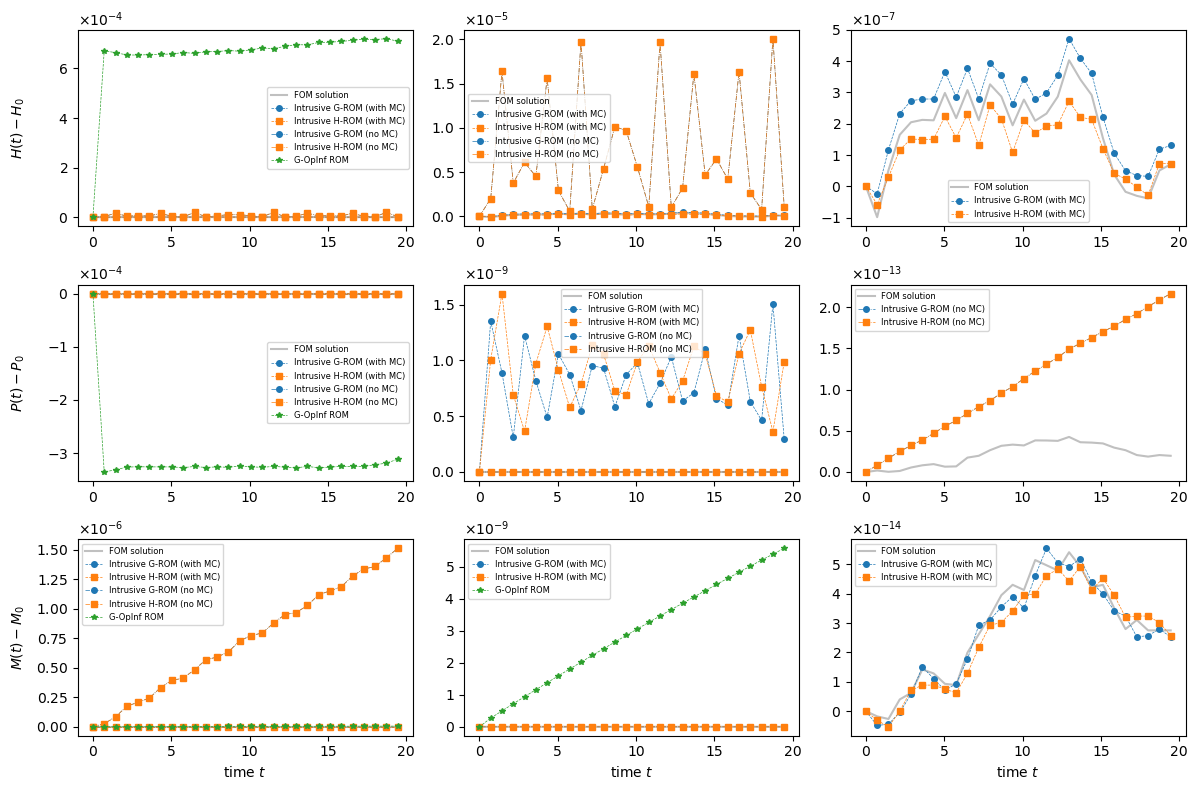

In [11]:
i=-1
fig, ax = plt.subplots(3, 3, figsize=(12,8))


yLabelList   = [r'$H(t) - H_0$', r'$P(t) - P_0$', r'$M(t) - M_0$']
# titleList    = ['All', 'No G-OpInf ROM', 'H-ROMs']

exact   = ku.KdV_Hamil_v1(Xtest, dx)
IntGerrMC = ku.KdV_Hamil_v1(XrecIntGMC[i], dx)
IntHerrMC = ku.KdV_Hamil_v1(XrecIntHMC[i], dx)
IntGerr = ku.KdV_Hamil_v1(XrecIntG[i], dx)
IntHerr = ku.KdV_Hamil_v1(XrecIntH[i], dx)
Operr   = ku.KdV_Hamil_v1(XrecOp[i], dx)

exact  -=exact[0]
IntGerrMC-=IntGerrMC[0]
IntHerrMC-=IntHerrMC[0]
IntGerr-=IntGerr[0]
IntHerr-=IntHerr[0]
Operr  -=Operr[0]

skip=36

ax[0,0].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[0,0].plot(tTest[::skip], IntGerrMC[::skip], label='Intrusive G-ROM (with MC)', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[0,0].plot(tTest[::skip], IntHerrMC[::skip], label='Intrusive H-ROM (with MC)', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[0,0].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM (no MC)', color=cmap.colors[0], marker='o', linestyle='-.', linewidth=0.5, markersize=4)
ax[0,0].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM (no MC)', color=cmap.colors[1], marker='s', linestyle='-.', linewidth=0.5, markersize=4)
ax[0,0].plot(tTest[::skip], Operr[::skip], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax[0,1].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[0,1].plot(tTest[::skip], IntGerrMC[::skip], label='Intrusive G-ROM (with MC)', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[0,1].plot(tTest[::skip], IntHerrMC[::skip], label='Intrusive H-ROM (with MC)', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[0,1].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM (no MC)', color=cmap.colors[0], marker='o', linestyle='-.', linewidth=0.5, markersize=4)
ax[0,1].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM (no MC)', color=cmap.colors[1], marker='s', linestyle='-.', linewidth=0.5, markersize=4)
ax[0,2].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[0,2].plot(tTest[::skip], IntGerrMC[::skip], label='Intrusive G-ROM (with MC)', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[0,2].plot(tTest[::skip], IntHerrMC[::skip], label='Intrusive H-ROM (with MC)', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
# ax[0,2].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM (no MC)', color=cmap.colors[0], marker='o', linestyle='-.', linewidth=0.5, markersize=4)
# ax[0,2].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM (no MC)', color=cmap.colors[1], marker='s', linestyle='-.', linewidth=0.5, markersize=4)

exact   = ku.KdV_Hamil_v2(Xtest, dx)
IntGerrMC = ku.KdV_Hamil_v2(XrecIntGMC[i], dx)
IntHerrMC = ku.KdV_Hamil_v2(XrecIntHMC[i], dx)
IntGerr = ku.KdV_Hamil_v2(XrecIntG[i], dx)
IntHerr = ku.KdV_Hamil_v2(XrecIntH[i], dx)
Operr   = ku.KdV_Hamil_v2(XrecOp[i], dx)

exact  -=exact[0]
IntGerrMC-=IntGerrMC[0]
IntHerrMC-=IntHerrMC[0]
IntGerr-=IntGerr[0]
IntHerr-=IntHerr[0]
Operr  -=Operr[0]

ax[1,0].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[1,0].plot(tTest[::skip], IntGerrMC[::skip], label='Intrusive G-ROM (with MC)', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[1,0].plot(tTest[::skip], IntHerrMC[::skip], label='Intrusive H-ROM (with MC)', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[1,0].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM (no MC)', color=cmap.colors[0], marker='o', linestyle='-.', linewidth=0.5, markersize=4)
ax[1,0].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM (no MC)', color=cmap.colors[1], marker='s', linestyle='-.', linewidth=0.5, markersize=4)
ax[1,0].plot(tTest[::skip], Operr[::skip], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax[1,1].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[1,1].plot(tTest[::skip], IntGerrMC[::skip], label='Intrusive G-ROM (with MC)', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[1,1].plot(tTest[::skip], IntHerrMC[::skip], label='Intrusive H-ROM (with MC)', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[1,1].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM (no MC)', color=cmap.colors[0], marker='o', linestyle='-.', linewidth=0.5, markersize=4)
ax[1,1].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM (no MC)', color=cmap.colors[1], marker='s', linestyle='-.', linewidth=0.5, markersize=4)
ax[1,2].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
# ax[1,2].plot(tTest[::skip], IntGerrMC[::skip], label='Intrusive G-ROM (with MC)', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
# ax[1,2].plot(tTest[::skip], IntHerrMC[::skip], label='Intrusive H-ROM (with MC)', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[1,2].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM (no MC)', color=cmap.colors[0], marker='o', linestyle='-.', linewidth=0.5, markersize=4)
ax[1,2].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM (no MC)', color=cmap.colors[1], marker='s', linestyle='-.', linewidth=0.5, markersize=4)

exact   = np.sum(Xtest,0)*dx
IntGerrMC = np.sum(XrecIntGMC[i],0)*dx
IntHerrMC = np.sum(XrecIntHMC[i],0)*dx
IntGerr = np.sum(XrecIntG[i],0)*dx
IntHerr = np.sum(XrecIntH[i],0)*dx
Operr   = np.sum(XrecOp[i],0)*dx

exact  -=exact[0]
IntGerrMC-=IntGerrMC[0]
IntHerrMC-=IntHerrMC[0]
IntGerr-=IntGerr[0]
IntHerr-=IntHerr[0]
Operr  -=Operr[0]

ax[2,0].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[2,0].plot(tTest[::skip], IntGerrMC[::skip], label='Intrusive G-ROM (with MC)', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[2,0].plot(tTest[::skip], IntHerrMC[::skip], label='Intrusive H-ROM (with MC)', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[2,0].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM (no MC)', color=cmap.colors[0], marker='o', linestyle='-.', linewidth=0.5, markersize=4)
ax[2,0].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM (no MC)', color=cmap.colors[1], marker='s', linestyle='-.', linewidth=0.5, markersize=4)
ax[2,0].plot(tTest[::skip], Operr[::skip], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax[2,1].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[2,1].plot(tTest[::skip], IntGerrMC[::skip], label='Intrusive G-ROM (with MC)', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[2,1].plot(tTest[::skip], IntHerrMC[::skip], label='Intrusive H-ROM (with MC)', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
# ax[2,1].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM (no MC)', color=cmap.colors[0], marker='o', linestyle='-.', linewidth=0.5, markersize=4)
# ax[2,1].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM (no MC)', color=cmap.colors[1], marker='s', linestyle='-.', linewidth=0.5, markersize=4)
ax[2,1].plot(tTest[::skip], Operr[::skip], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax[2,2].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[2,2].plot(tTest[::skip], IntGerrMC[::skip], label='Intrusive G-ROM (with MC)', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[2,2].plot(tTest[::skip], IntHerrMC[::skip], label='Intrusive H-ROM (with MC)', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
# ax[2,2].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM (no MC)', color=cmap.colors[0], marker='o', linestyle='-.', linewidth=0.5, markersize=4)
# ax[2,2].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM (no MC)', color=cmap.colors[1], marker='s', linestyle='-.', linewidth=0.5, markersize=4)

for j in range(9):
    ax.flatten()[j].legend(prop={'size':6})
    ax.flatten()[j].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
for j in range(3):
    ax[j,0].set_ylabel(f'{yLabelList[j]}', loc='center', labelpad=2.0)
    ax[j,0].yaxis.set_label_coords(-0.15,0.5)
    ax[-1,j].set_xlabel('time $t$')
    # ax[0,j].set_title(f'{titleList[j]}')


plt.tight_layout()
# plt.savefig(f'KdVConserved{4*(i+1)}modesT{T}v2', transparent=True)
plt.show()

# i=7
# dx = xTrain[1]-xTrain[0]
# dt = tTest[1]-tTest[0]
# extent = [xTrain[0]-dx, xTrain[-1]+dx, tTest[0]-dt, tTest[-1]+dt]

# titleList = ['FOM Solution', 'Intrusive G-ROM', 'Intrusive H-ROM', 'G-OpInf ROM', 'NC-H-OpInf ROM']

# from mpl_toolkits.axes_grid1 import ImageGrid

# fig = plt.figure(figsize=(12,4))

# grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
#                  nrows_ncols=(1,5),
#                  axes_pad=0.25,
#                  share_all=True,
#                  cbar_location="right",
#                  cbar_mode="single",
#                  cbar_size="7%",
#                  cbar_pad=0.15,
#                  )

# im = grid[0].imshow(Xtest.T, extent=extent, cmap='cividis', vmin=-0.5, vmax=0.5)
# im = grid[1].imshow(XrecIntGMC[i].T, extent=extent, cmap='cividis', vmin=-0.5, vmax=0.5)
# im = grid[2].imshow(XrecIntHMC[i].T, extent=extent, cmap='cividis', vmin=-0.5, vmax=0.5)
# im = grid[3].imshow(XrecOp[i].T, extent=extent, cmap='cividis', vmin=-0.5, vmax=0.5)
# # im = grid[4].imshow(XrecHOpMC[i].T, extent=extent, cmap='cividis', vmin=-0.5, vmax=0.5)
# for j in range(5):
#     grid[j].set_title(f'{titleList[j]}')
#     grid[j].set_xlabel('space $s$')
# grid[0].set_ylabel('time $t$')

# grid[-1].cax.colorbar(im)
# grid[-1].cax.toggle_label(True)

# plt.tight_layout()
# # plt.savefig(f'KdVimshow{4*(i+1)}ModesT{T}', transparent=True, bbox_inches='tight')
# plt.show()

### Computing ROMs in predictive case

the relative L2 errors for intrusive H-ROM (MC) are [1.33566326 1.35061181 1.36142206 1.343104   1.31238207 1.34223603
 1.32431722 1.31316169 1.30692322 1.30396713 1.30267611 1.30216041
 1.30196373 1.30189172 1.30186617 1.30185733 1.30185433 1.30185334]
the relative L2 errors for intrusive H-ROM (no MC) are [1.04388024e+00 1.18438415e+00 1.26825062e+00 1.34134974e+00
 1.30351880e+00 1.19487463e+00 8.95289313e-01 5.33124206e-01
 4.33445860e-01 4.29087084e-02 2.42748940e-02 1.22555281e-02
 7.95235289e-03 8.84735186e-03 2.49169293e-03 2.15886633e-03
 1.29934862e-03 5.82709225e-04]
the relative L2 errors for intrusive G-ROM (MC) are [1.34706238e+00 1.36275218e+00 1.34437623e+00 1.32487479e+00
 1.31275468e+00 1.21093032e+00 9.49731676e-01 5.28389451e-01
 2.40205433e-01 9.51821862e-02 3.67690189e-02 1.37814714e-02
 5.01106729e-03 1.81520169e-03 6.71015402e-04 2.64822987e-04
 1.15683571e-04 5.56347259e-05]
the relative L2 errors for intrusive G-ROM (no MC) are [1.04388024e+00 1.18438415e+00 1

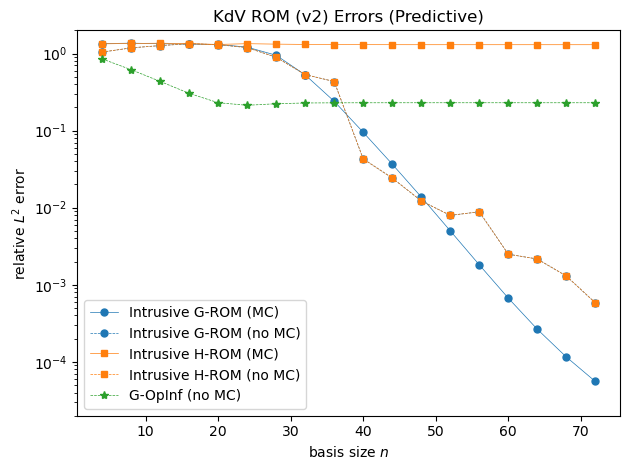

In [12]:
T         = 100
NtTest    = 1000
tTest     = np.linspace(0, T, NtTest)
dt        = tTest[1]-tTest[0]

Xtest = ku.integrate_KdV_v2_FOM(tTest, ic, A, E)[0]
# Xtest = X2

nList  = [4*(i+1) for i in range(18)]
eOp    = np.zeros(len(nList))
eIntG   = np.zeros(len(nList))
eIntGMC = np.zeros(len(nList))
eIntH   = np.zeros(len(nList))
eIntHMC = np.zeros(len(nList))

XrecIntG   = np.zeros((len(nList), N, NtTest))
XrecIntGMC = np.zeros((len(nList), N, NtTest))
XrecIntH   = np.zeros((len(nList), N, NtTest))
XrecIntHMC = np.zeros((len(nList), N, NtTest))
XrecOp     = np.zeros((len(nList), N, NtTest))

OpInfLists  = ou.build_OpInf_stuff(UU2, X2, Xd2, gH2, A, nList[-1])

DhatOpFull    = ou.G_OpInf(OpInfLists[-1], nList[-1], SS2, eps=1.0e-15)

for i,n in enumerate(nList):
    DhatOp         = DhatOpFull[:n,:n]

    XrecIntGMC[i] = ku.integrate_KdV_v2_ROM(tTest, OpListMC2G, ic, UU2mc, n, 
                                         MC=True, Newton=True)
    XrecIntHMC[i] = ku.integrate_KdV_v2_ROM(tTest, OpListMC2, ic, UU2mc, n, 
                                         MC=True, Newton=True)

    XrecIntG[i]   = ku.integrate_KdV_v2_ROM(tTest, OpList2G, ic, UU2, n, 
                                         MC=False, Newton=True)
    XrecIntH[i]   = ku.integrate_KdV_v2_ROM(tTest, OpList2, ic, UU2, n, 
                                         MC=False, Newton=True)

    XrecOp[i]    = ru.integrate_OpInf_ROM(tTest, DhatOp, ic, UU2)

    eIntGMC[i]   = ru.relError(Xtest, XrecIntGMC[i])
    eIntG[i] = ru.relError(Xtest, XrecIntG[i])
    eIntHMC[i]   = ru.relError(Xtest, XrecIntHMC[i])
    eIntH[i] = ru.relError(Xtest, XrecIntH[i])
    eOp[i]    = ru.relError(Xtest, XrecOp[i])

# Print error magnitudes
print(f'the relative L2 errors for intrusive H-ROM (MC) are {eIntHMC}')
print(f'the relative L2 errors for intrusive H-ROM (no MC) are {eIntH}')
print(f'the relative L2 errors for intrusive G-ROM (MC) are {eIntGMC}')
print(f'the relative L2 errors for intrusive G-ROM (no MC) are {eIntG}')
print(f'the relative L2 errors for generic OpInf are {eOp}')

name = "tab10"
cmap = get_cmap(name)

plt.semilogy(nList, eIntGMC, label='Intrusive G-ROM (MC)',
             marker='o', linestyle='-', color=cmap.colors[0], linewidth=0.5, markersize=5)
plt.semilogy(nList, eIntG, label='Intrusive G-ROM (no MC)',
             marker='o', linestyle='--', color=cmap.colors[0], linewidth=0.5, markersize=5)
plt.semilogy(nList, eIntHMC, label='Intrusive H-ROM (MC)',
             marker='s', linestyle='-', color=cmap.colors[1], linewidth=0.5, markersize=5)
plt.semilogy(nList, eIntH, label='Intrusive H-ROM (no MC)',
             marker='s', linestyle='--', color=cmap.colors[1], linewidth=0.5, markersize=5)
plt.semilogy(nList, eOp,  label='G-OpInf (no MC)',
             marker='*', linestyle='--', color=cmap.colors[2], linewidth=0.5, markersize=6)
plt.ylabel('relative $L^2$ error')
plt.xlabel('basis size $n$')
plt.title('KdV ROM (v2) Errors (Predictive)')
plt.ylim([2*10**-5,2.])
plt.legend(loc=3)

plt.tight_layout()
# plt.savefig(f'KdVPlotT{T}v2', transparent=True)
plt.show()

### Plots of conserved quantities in predictive case

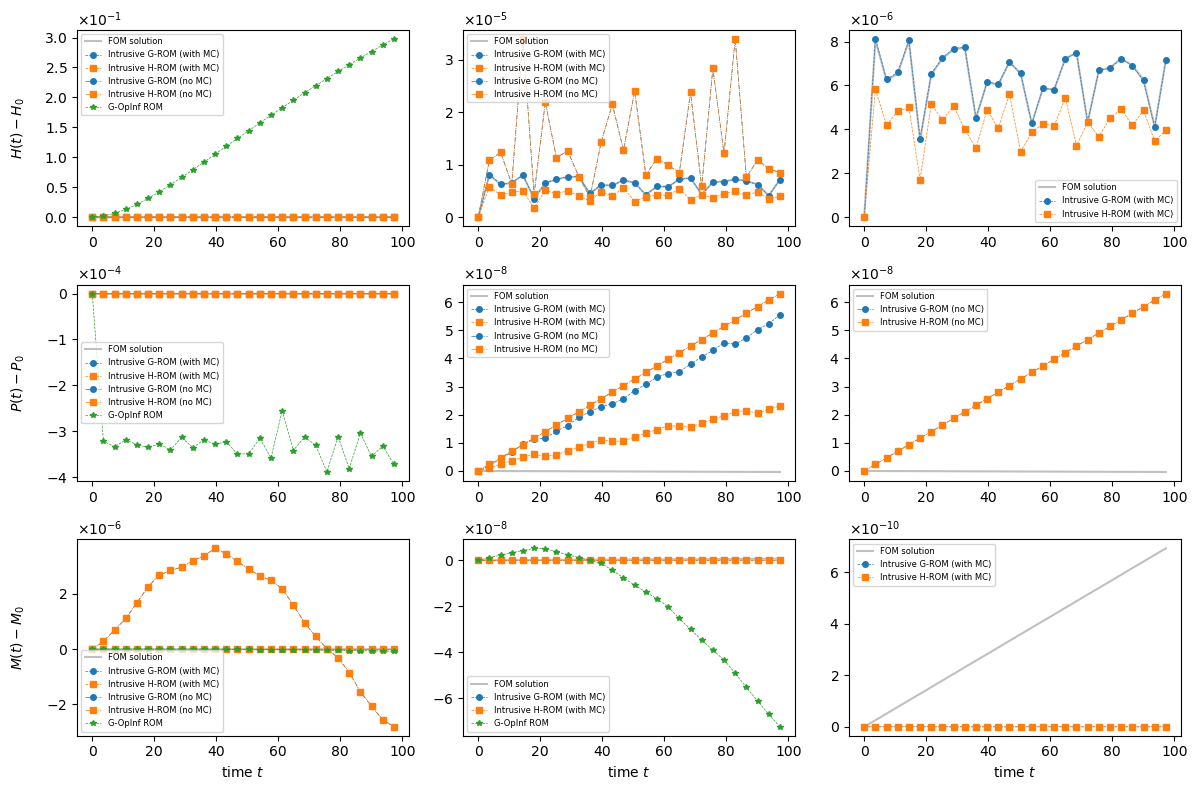

In [13]:
i=-1
fig, ax = plt.subplots(3, 3, figsize=(12,8))


yLabelList   = [r'$H(t) - H_0$', r'$P(t) - P_0$', r'$M(t) - M_0$']
# titleList    = ['All', 'No G-OpInf ROM', 'H-ROMs']

exact   = ku.KdV_Hamil_v1(Xtest, dx)
IntGerrMC = ku.KdV_Hamil_v1(XrecIntGMC[i], dx)
IntHerrMC = ku.KdV_Hamil_v1(XrecIntHMC[i], dx)
IntGerr = ku.KdV_Hamil_v1(XrecIntG[i], dx)
IntHerr = ku.KdV_Hamil_v1(XrecIntH[i], dx)
Operr   = ku.KdV_Hamil_v1(XrecOp[i], dx)

exact  -=exact[0]
IntGerrMC-=IntGerrMC[0]
IntHerrMC-=IntHerrMC[0]
IntGerr-=IntGerr[0]
IntHerr-=IntHerr[0]
Operr  -=Operr[0]

skip=36

ax[0,0].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[0,0].plot(tTest[::skip], IntGerrMC[::skip], label='Intrusive G-ROM (with MC)', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[0,0].plot(tTest[::skip], IntHerrMC[::skip], label='Intrusive H-ROM (with MC)', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[0,0].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM (no MC)', color=cmap.colors[0], marker='o', linestyle='-.', linewidth=0.5, markersize=4)
ax[0,0].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM (no MC)', color=cmap.colors[1], marker='s', linestyle='-.', linewidth=0.5, markersize=4)
ax[0,0].plot(tTest[::skip], Operr[::skip], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax[0,1].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[0,1].plot(tTest[::skip], IntGerrMC[::skip], label='Intrusive G-ROM (with MC)', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[0,1].plot(tTest[::skip], IntHerrMC[::skip], label='Intrusive H-ROM (with MC)', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[0,1].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM (no MC)', color=cmap.colors[0], marker='o', linestyle='-.', linewidth=0.5, markersize=4)
ax[0,1].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM (no MC)', color=cmap.colors[1], marker='s', linestyle='-.', linewidth=0.5, markersize=4)
ax[0,2].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[0,2].plot(tTest[::skip], IntGerrMC[::skip], label='Intrusive G-ROM (with MC)', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[0,2].plot(tTest[::skip], IntHerrMC[::skip], label='Intrusive H-ROM (with MC)', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
# ax[0,2].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM (no MC)', color=cmap.colors[0], marker='o', linestyle='-.', linewidth=0.5, markersize=4)
# ax[0,2].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM (no MC)', color=cmap.colors[1], marker='s', linestyle='-.', linewidth=0.5, markersize=4)

exact   = ku.KdV_Hamil_v2(Xtest, dx)
IntGerrMC = ku.KdV_Hamil_v2(XrecIntGMC[i], dx)
IntHerrMC = ku.KdV_Hamil_v2(XrecIntHMC[i], dx)
IntGerr = ku.KdV_Hamil_v2(XrecIntG[i], dx)
IntHerr = ku.KdV_Hamil_v2(XrecIntH[i], dx)
Operr   = ku.KdV_Hamil_v2(XrecOp[i], dx)

exact  -=exact[0]
IntGerrMC-=IntGerrMC[0]
IntHerrMC-=IntHerrMC[0]
IntGerr-=IntGerr[0]
IntHerr-=IntHerr[0]
Operr  -=Operr[0]

ax[1,0].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[1,0].plot(tTest[::skip], IntGerrMC[::skip], label='Intrusive G-ROM (with MC)', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[1,0].plot(tTest[::skip], IntHerrMC[::skip], label='Intrusive H-ROM (with MC)', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[1,0].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM (no MC)', color=cmap.colors[0], marker='o', linestyle='-.', linewidth=0.5, markersize=4)
ax[1,0].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM (no MC)', color=cmap.colors[1], marker='s', linestyle='-.', linewidth=0.5, markersize=4)
ax[1,0].plot(tTest[::skip], Operr[::skip], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax[1,1].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[1,1].plot(tTest[::skip], IntGerrMC[::skip], label='Intrusive G-ROM (with MC)', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[1,1].plot(tTest[::skip], IntHerrMC[::skip], label='Intrusive H-ROM (with MC)', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[1,1].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM (no MC)', color=cmap.colors[0], marker='o', linestyle='-.', linewidth=0.5, markersize=4)
ax[1,1].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM (no MC)', color=cmap.colors[1], marker='s', linestyle='-.', linewidth=0.5, markersize=4)
ax[1,2].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
# ax[1,2].plot(tTest[::skip], IntGerrMC[::skip], label='Intrusive G-ROM (with MC)', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
# ax[1,2].plot(tTest[::skip], IntHerrMC[::skip], label='Intrusive H-ROM (with MC)', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[1,2].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM (no MC)', color=cmap.colors[0], marker='o', linestyle='-.', linewidth=0.5, markersize=4)
ax[1,2].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM (no MC)', color=cmap.colors[1], marker='s', linestyle='-.', linewidth=0.5, markersize=4)

exact   = np.sum(Xtest,0)*dx
IntGerrMC = np.sum(XrecIntGMC[i],0)*dx
IntHerrMC = np.sum(XrecIntHMC[i],0)*dx
IntGerr = np.sum(XrecIntG[i],0)*dx
IntHerr = np.sum(XrecIntH[i],0)*dx
Operr   = np.sum(XrecOp[i],0)*dx

exact  -=exact[0]
IntGerrMC-=IntGerrMC[0]
IntHerrMC-=IntHerrMC[0]
IntGerr-=IntGerr[0]
IntHerr-=IntHerr[0]
Operr  -=Operr[0]

ax[2,0].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[2,0].plot(tTest[::skip], IntGerrMC[::skip], label='Intrusive G-ROM (with MC)', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[2,0].plot(tTest[::skip], IntHerrMC[::skip], label='Intrusive H-ROM (with MC)', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax[2,0].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM (no MC)', color=cmap.colors[0], marker='o', linestyle='-.', linewidth=0.5, markersize=4)
ax[2,0].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM (no MC)', color=cmap.colors[1], marker='s', linestyle='-.', linewidth=0.5, markersize=4)
ax[2,0].plot(tTest[::skip], Operr[::skip], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax[2,1].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[2,1].plot(tTest[::skip], IntGerrMC[::skip], label='Intrusive G-ROM (with MC)', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[2,1].plot(tTest[::skip], IntHerrMC[::skip], label='Intrusive H-ROM (with MC)', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
# ax[2,1].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM (no MC)', color=cmap.colors[0], marker='o', linestyle='-.', linewidth=0.5, markersize=4)
# ax[2,1].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM (no MC)', color=cmap.colors[1], marker='s', linestyle='-.', linewidth=0.5, markersize=4)
ax[2,1].plot(tTest[::skip], Operr[::skip], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax[2,2].plot(tTest[::skip], exact[::skip], label='FOM solution', color='silver', linestyle='-')
ax[2,2].plot(tTest[::skip], IntGerrMC[::skip], label='Intrusive G-ROM (with MC)', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax[2,2].plot(tTest[::skip], IntHerrMC[::skip], label='Intrusive H-ROM (with MC)', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
# ax[2,2].plot(tTest[::skip], IntGerr[::skip], label='Intrusive G-ROM (no MC)', color=cmap.colors[0], marker='o', linestyle='-.', linewidth=0.5, markersize=4)
# ax[2,2].plot(tTest[::skip], IntHerr[::skip], label='Intrusive H-ROM (no MC)', color=cmap.colors[1], marker='s', linestyle='-.', linewidth=0.5, markersize=4)

for j in range(9):
    ax.flatten()[j].legend(prop={'size':6})
    ax.flatten()[j].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
for j in range(3):
    ax[j,0].set_ylabel(f'{yLabelList[j]}', loc='center', labelpad=2.0)
    ax[j,0].yaxis.set_label_coords(-0.15,0.5)
    ax[-1,j].set_xlabel('time $t$')
    # ax[0,j].set_title(f'{titleList[j]}')

plt.tight_layout()
# plt.savefig(f'KdVConserved{4*(i+1)}modesT{T}v2', transparent=True)
plt.show()

# i=7
# dx = xTrain[1]-xTrain[0]
# dt = tTest[1]-tTest[0]
# extent = [xTrain[0]-dx, xTrain[-1]+dx, tTest[0]-dt, tTest[-1]+dt]

# titleList = ['FOM Solution', 'Intrusive G-ROM', 'Intrusive H-ROM', 'G-OpInf ROM', 'NC-H-OpInf ROM']

# from mpl_toolkits.axes_grid1 import ImageGrid

# fig = plt.figure(figsize=(12,4))

# grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
#                  nrows_ncols=(1,5),
#                  axes_pad=0.25,
#                  share_all=True,
#                  cbar_location="right",
#                  cbar_mode="single",
#                  cbar_size="7%",
#                  cbar_pad=0.15,
#                  )

# im = grid[0].imshow(Xtest.T, extent=extent, cmap='cividis', vmin=-0.5, vmax=0.5)
# im = grid[1].imshow(XrecIntGMC[i].T, extent=extent, cmap='cividis', vmin=-0.5, vmax=0.5)
# im = grid[2].imshow(XrecIntHMC[i].T, extent=extent, cmap='cividis', vmin=-0.5, vmax=0.5)
# im = grid[3].imshow(XrecOp[i].T, extent=extent, cmap='cividis', vmin=-0.5, vmax=0.5)
# # im = grid[4].imshow(XrecHOpMC[i].T, extent=extent, cmap='cividis', vmin=-0.5, vmax=0.5)
# for j in range(5):
#     grid[j].set_title(f'{titleList[j]}')
#     grid[j].set_xlabel('space $s$')
# grid[0].set_ylabel('time $t$')

# grid[-1].cax.colorbar(im)
# grid[-1].cax.toggle_label(True)

# plt.tight_layout()
# # plt.savefig(f'KdVimshow{4*(i+1)}ModesT{T}', transparent=True, bbox_inches='tight')
# plt.show()